- **download dependent packages**

In [ ]:
!pip install -r requriements.txt

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from utils.data_loader import get_data
from utils.train_func import train_model
from models.ResNet import resnet50

# load data

In [27]:
np.load?

In [24]:
nb_data = 10000
sig = np.load('./data/zz_4j_train_arr.npy')[:nb_data]
bg = np.load('./data/ww_4j_train_arr.npy')[:nb_data]

In [ ]:
np.load('./data/zz_4j_train_arr.npy', allow_pickle=True)

# train and save model

In [3]:
r, c = 50, 50
num_epochs = 5
batch_size = 512
test_size = 0.2
lr = 0.001
use_gpu = True


device = torch.device('cuda:0') if use_gpu else torch.device('cpu')
dataloaders = get_data(sig=sig, 
                       bg=bg, 
                       r=r,
                       c=c,
                       batch_size=batch_size, 
                       test_size=test_size,
                       use_gpu=use_gpu)
criterion = torch.nn.BCELoss()
model = resnet50(nb_ch=1)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=1e-5)
model, history = train_model(model=model, 
                             dataloaders=dataloaders, 
                             criterion=criterion, 
                             optimizer=optimizer, 
                             num_epochs=num_epochs, 
                             device=device)
torch.save(model.state_dict(), 'saved_model/resnet50_model.pt')

Epoch 0/4
Epoch Loss: 0.993757, Acc: 0.545500, Val Loss: 0.699998, Val Acc: 0.601437
----------
Epoch 1/4
Epoch Loss: 0.679831, Acc: 0.602812, Val Loss: 0.619176, Val Acc: 0.658062
----------
Epoch 2/4
Epoch Loss: 0.725325, Acc: 0.635875, Val Loss: 0.682920, Val Acc: 0.657375
----------
Epoch 3/4
Epoch Loss: 0.648971, Acc: 0.663188, Val Loss: 0.625213, Val Acc: 0.650938
----------
Epoch 4/4
Epoch Loss: 0.657307, Acc: 0.663375, Val Loss: 0.622518, Val Acc: 0.726750
----------
Training complete in 1m 58s


# visualize training

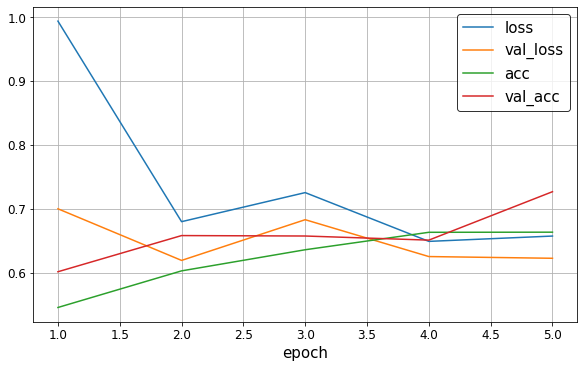

In [4]:
plot_params = {
    'linewidth': 1.5,
    'alpha': 1,
}

fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
for key in history:
    ax.plot([x + 1 for x in range(num_epochs)], history[key], label=key, **plot_params)
ax.legend(loc='best', fontsize=15, edgecolor='k')
ax.set_xlabel('epoch', fontsize=15)
ax.grid(True)
ax.tick_params(labelsize=12)
plt.show()

# load model and evaluate

In [5]:
nb_data = 1000
sig = np.load('./data/zz_4j_test_arr.npy')[:nb_data]
bg = np.load('./data/ww_4j_test_arr.npy')[:nb_data]

In [6]:
from utils.data_loader import MyDataset
from utils.lorentz import to_p4

In [9]:
torch.utils.data.DataLoader?

In [14]:
def eva(model, data, r, c, batch_size, use_gpu=True):
    data_p4 = to_p4(data)
    dataset = MyDataset(data_p4, np.zeros((len(data), 1)), r, c)
    pin_memory = True if use_gpu else False
    device = torch.device('cuda:0') if use_gpu else torch.device('cpu') 
    dataloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=batch_size,
                    num_workers=6,
                    pin_memory=pin_memory,)
    model = model.to(device)
    model.eval()
    for i, (input, _) in enumerate(dataloader):
        input = input.to(device).float()
        batch_out = model(input).cpu().detach().numpy()
        if i==0:
            out = batch_out
        else:
            out = np.concatenate((out, batch_out), axis=0)
    return out

In [15]:
batch_size = 512
use_gpu = True

model = resnet50(nb_ch=1)
model.load_state_dict(torch.load('./saved_model/resnet50_model.pt'))

sig_out = eva(model, sig, r, c, batch_size, use_gpu=use_gpu)
bg_out = eva(model, bg, r, c, batch_size, use_gpu=use_gpu)

## visualize distribution and ROC

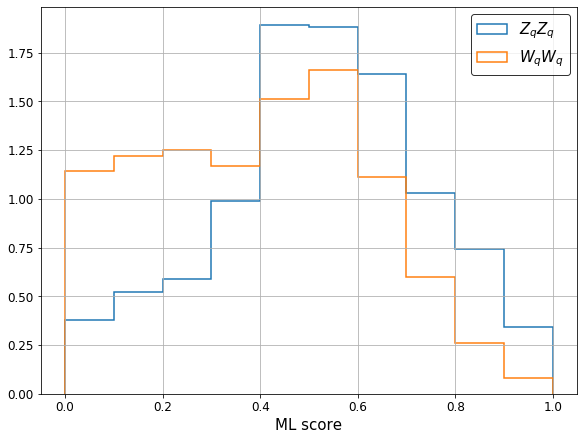

In [16]:
plot_params = {
    'bins': 10,
    'range': (0, 1),
    'linewidth': 1.5,
    'histtype': 'step',
    'alpha': 1,
    'density': True
}

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
ax.hist(sig_out, label=r'$Z_qZ_q$', **plot_params)
ax.hist(bg_out, label=r'$W_qW_q$', **plot_params)
ax.legend(loc='best', fontsize=15, edgecolor='k')
ax.set_xlabel('ML score', fontsize=15)
ax.grid(True)
ax.tick_params(labelsize=12)
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = np.concatenate((np.ones(len(sig_out)), np.zeros(len(bg_out))), axis=0)
y_pred = np.concatenate((sig_out, bg_out), axis=0)
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)

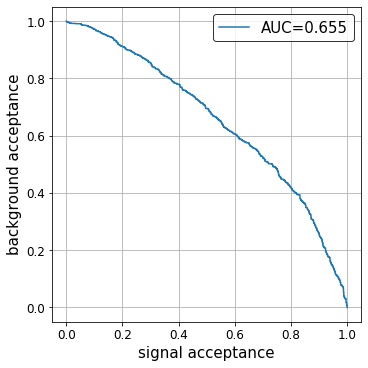

In [18]:
plot_params = {
    'linewidth': 1.5,
    'alpha': 1,
}

fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.plot(tpr, 1-fpr, label='AUC=%.3f'%auc, **plot_params)
ax.legend(loc='best', fontsize=15, edgecolor='k')
ax.set_xlabel('signal acceptance', fontsize=15)
ax.set_ylabel('background acceptance', fontsize=15)
ax.grid(True)
ax.tick_params(labelsize=12)
plt.show()